<a href="https://colab.research.google.com/github/aswinaus/Reinforcement-Learning/blob/main/Important_Calculating_Loss_in_GRPO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Calculating loss in GRPO

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

Let's take a closer look at how loss is calculated in the GRPO algorithm. This is the critical step that helps your large language model (LLM) learn from its training experiences.​

The **GRPO algorithm** was introduced in the **DeepSeek R1** paper. At first glance, it might seem quite complex.
However, the core loss function can actually be broken down into four key components, which we'll explore one
by one.

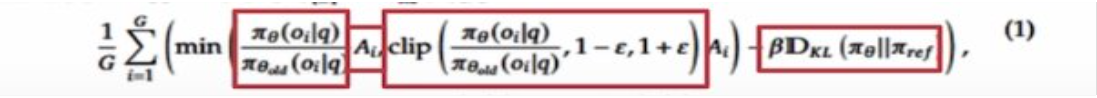


The first component is the **policy loss**. This represents the ratio between the token probability distributions
generated by your model with and without the adapter applied.​


The second component is the **advantage term**. You might already be familiar with this—it’s calculated from
earlier reward functions and helps the model understand which actions were beneficial.

The third component is the **clipping objective**. This helps prevent large loss values from any individual training
step, ensuring that learning remains stable and controlled.​

The final component is the **KL divergence**. This ensures the model being trained doesn't drift too far from the
baseline knowledge it already possesses. In other words, it helps the model continue learning without
"forgetting" what it previously knew.

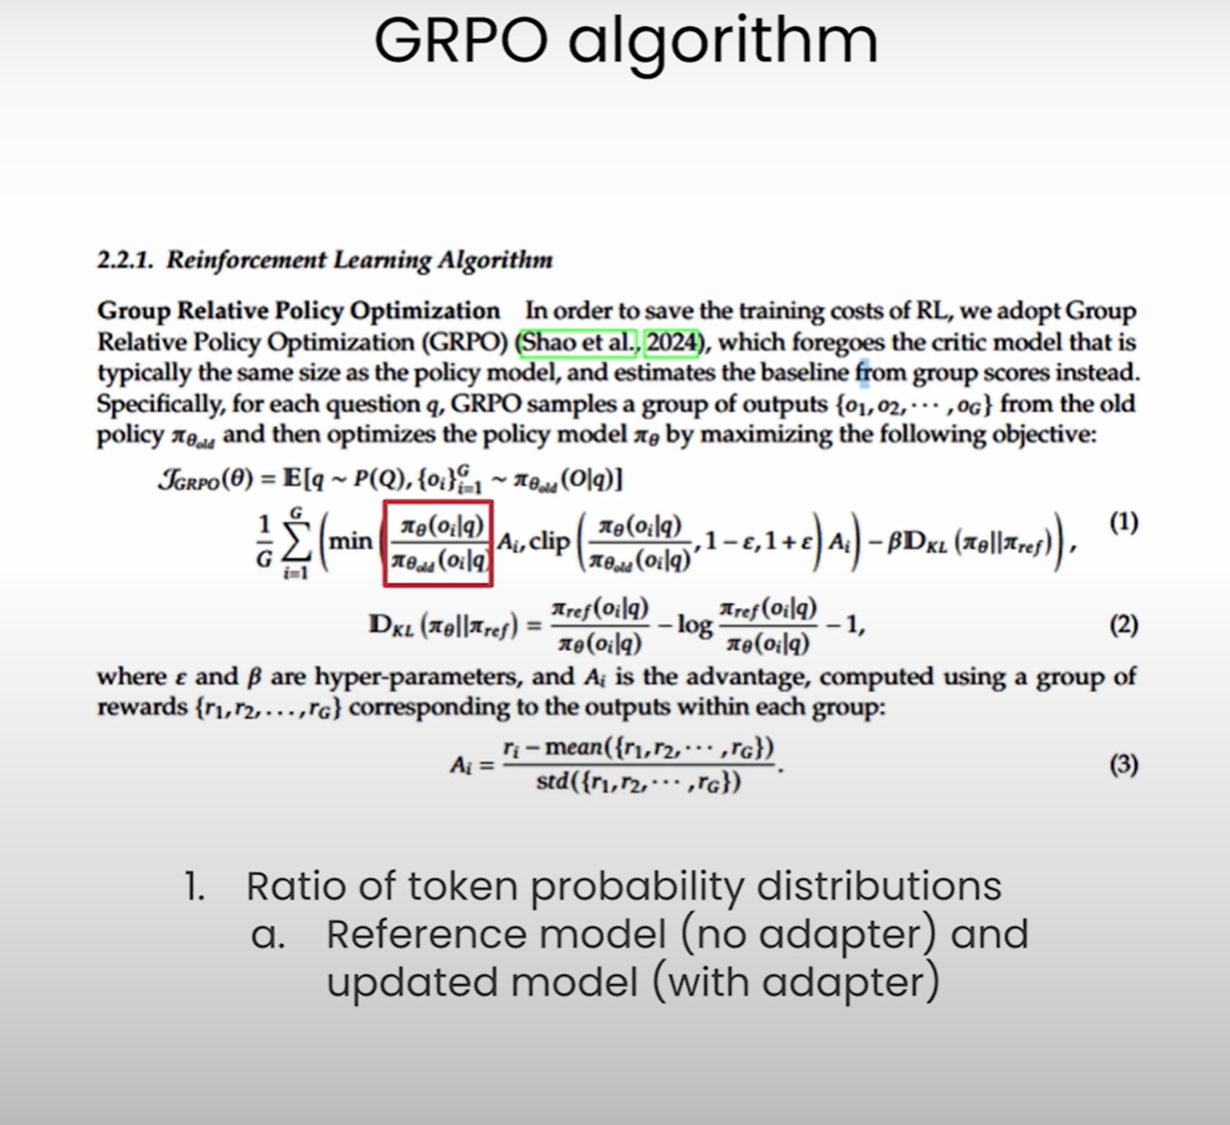

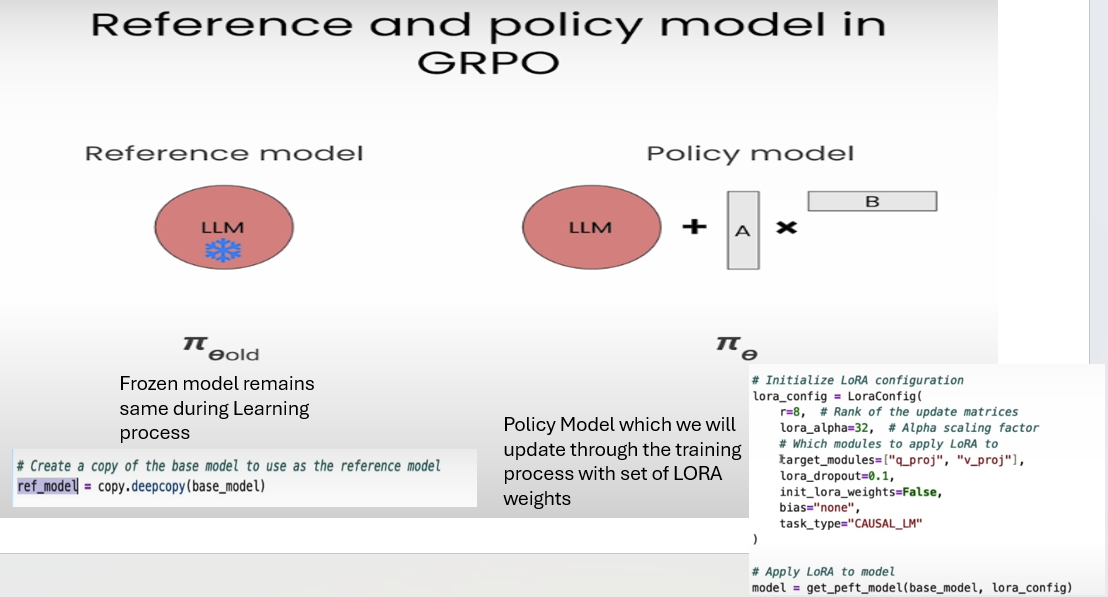

Start by loading dependencies and BabyLLama, a small LLM to use in this lesson:

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
# Initialize model and tokenizer
model_str = 'babylm/babyllama-100m-2024'
base_model = AutoModelForCausalLM.from_pretrained(model_str)
tokenizer = AutoTokenizer.from_pretrained(model_str)
# pad on the left so we can append new tokens on the right
tokenizer.padding_side = "left"
tokenizer.truncation_side = "left"

In [ ]:
print(base_model)

In [ ]:
import torch
import torch.nn as nn

prompt = "The quick brown fox jumped over the "

# Tokenize the prompt
input_ids = tokenizer(prompt, return_tensors="pt")
print(input_ids)

# Generate next 2 tokens
with torch.no_grad():
    outputs = base_model.generate(
        **input_ids,
        max_new_tokens=2,
        pad_token_id=tokenizer.pad_token_id
    )
# Decode the generated text
generated_text = tokenizer.decode(
    outputs[0], skip_special_tokens=True
)
generated_portion = generated_text[len(prompt):]
print(f"Generated text: {prompt}\033[94m{generated_portion}\033[0m")

## Create reference and policy models

The **Reference Model** is the base LLM, and remains unchanged throughout training.

The **Policy Model** is the same model with a LoRA adapter applied - the weights of the LoRA adapter get updated throughout the RFT training process.

In [ ]:
import copy
from peft import LoraConfig, get_peft_model
# Create a copy of the base model to use as the reference model
ref_model = copy.deepcopy(base_model)
# Initialize LoRA configuration
lora_config = LoraConfig(
    r=8,  # Rank of the update matrices
    lora_alpha=32,  # Alpha scaling factor
    # Which modules to apply LoRA to
    target_modules=["q_proj", "v_proj"],
    lora_dropout=0.1,
    init_lora_weights=False,
    bias="none",
    task_type="CAUSAL_LM"
)
# Apply LoRA to model
model = get_peft_model(base_model, lora_config)

Examine the policy model:

In [ ]:
print(model)

## Calculating the policy loss ratio

This Function grpo_loss calculates the core policy loss component of the GRPO algorithm. This function helps in calculating how much the **policy model's** **probability distribution** for the generated completion differs from the **reference model's**, weighted by the advantage of that completion. This forms the basis for updating the policy model's weights to favor better completions.

In [ ]:
#This defines a function named prepare_inputs that takes two arguments:
#prompt (the input text given to the model) and
#completion (the text generated by the model).
def prepare_inputs(prompt, completion):
    # Tokenization
    # This line uses the tokenizer (which was loaded earlier in the notebook)
    # to convert the prompt string into a sequence of token IDs.
    # return_tensors="pt" specifies that the output should be PyTorch tensors.
    # The result, prompt_tokens, is a dictionary-like object
    # containing the token IDs and an attention mask for the prompt.
    prompt_tokens = tokenizer(prompt, return_tensors="pt")
    # Similar to the previous line, this tokenizes the completion string and returns
    # the result as PyTorch tensors in completion_tokens.
    completion_tokens = tokenizer(completion, return_tensors="pt")

    # Combined input
    # This line concatenates the input_ids tensors from both the prompt_tokens and completion_tokens
    # along dimension 1 (the sequence length dimension). This creates a single tensor
    # input_ids representing the combined sequence of prompt and completion tokens.
    input_ids = torch.cat(
        [
            prompt_tokens["input_ids"],
            completion_tokens["input_ids"]
        ],
        dim=1
    )
    # This line concatenates the attention_mask tensors from both the prompt_tokens and completion_tokens along dimension 1. The attention mask is used by the model to know which tokens
    # to attend to (usually 1 for actual tokens and 0 for padding tokens).
    attention_mask = torch.cat(
        [
            prompt_tokens["attention_mask"],
            completion_tokens["attention_mask"]
        ],
        dim=1
    )
    # This line gets the length (number of tokens) of the prompt sequence by accessing the shape
    # of the input_ids tensor from prompt_tokens and taking the value at index 1.
    prompt_length = prompt_tokens["input_ids"].shape[1]
    # This line gets the length of the completion sequence in the same way as the prompt length.
    completion_length = completion_tokens["input_ids"].shape[1]
    total_length = prompt_length + completion_length

    # Create a mask to identify the tokens that were generated by the model in the full sequence
    # This line initializes a tensor called completion_mask with all zeros.
    # The size of the tensor is equal to the total_length of the combined sequence, and its data type is set to float32.
    completion_mask = torch.zeros(total_length, dtype=torch.float32)
    # This line sets the values in the completion_mask to 1.0 starting from the index equal to prompt_length
    # all the way to the end of the tensor.
    # This creates a mask where the values corresponding to the prompt tokens are 0, and the values corresponding to the completion tokens
    # are 1.
    # This mask is used later in the grpo_loss function to ensure that the loss is only calculated for the generated completion tokens.
    completion_mask[prompt_length:] = 1.0
    # function returns the combined input_ids, the combined attention_mask, and the completion_mask.
    # These are the inputs needed for calculating the loss in the GRPO algorithm.
    return input_ids, attention_mask, completion_mask

In [ ]:
def compute_log_probs(model, input_ids, attention_mask):
    outputs = model(input_ids, attention_mask=attention_mask)

    # Computing the log-probability of each token in the sequence
    # outputs.logits is the logits for all tokens in the vocabulary for each position in the sequence
    log_probs = F.log_softmax(outputs.logits, dim=-1)

    # Extract the log-probability for the actual token that
    # was generated at each position in the sequence.
    return log_probs.gather(
        dim=-1,
        index=input_ids.unsqueeze(-1)
    ).squeeze(-1)

In [ ]:
def grpo_loss(model, ref_model, prompt, completion, advantage):
    input_ids, attention_mask, completion_mask = prepare_inputs(
        prompt, completion
    )

    # Model forward
    token_log_probs = compute_log_probs(
        model, input_ids, attention_mask
    )
    with torch.no_grad():
        ref_token_log_probs = compute_log_probs(
            ref_model, input_ids, attention_mask
    )

    # ratio = p_model / p_ref = exp(log(p_model) - log(p_ref))
    ratio = torch.exp(token_log_probs - ref_token_log_probs)

    # Scale the ratio by the advantage function
    policy_loss = ratio * advantage

    # We want to maximize reward, so we make the loss negative
    # because optimizers minimize loss.
    per_token_loss = -policy_loss

    # Only compute loss over the output tokens
    loss = (per_token_loss * completion_mask).sum() / completion_mask.sum()
    return loss

In [ ]:
import torch.nn.functional as F

def compute_log_probs(model, input_ids, attention_mask):
    outputs = model(input_ids, attention_mask=attention_mask)

    # Computing the log-probability of each token in the sequence
    # outputs.logits is the logits for all tokens in the vocabulary for each position in the sequence
    log_probs = F.log_softmax(outputs.logits, dim=-1)

    # Extract the log-probability for the actual token that
    # was generated at each position in the sequence.
    return log_probs.gather(
        dim=-1,
        index=input_ids.unsqueeze(-1)
    ).squeeze(-1)

In [ ]:
grpo_loss(model, ref_model, prompt, "fence and", advantage=2.0)

During the first step of training, the reference and policy models are identical. So the loss comes from the advantage of the reponse:

In [ ]:
# At step 1, the model and reference model are the same
# So the loss is the advantage function because the ratio of
# per-token log-probabilities is 1
grpo_loss(ref_model, ref_model, prompt, "fence and", advantage=2.0)

In [ ]:
completion = "fence and"

input_ids, attention_mask, completion_mask = prepare_inputs(
    prompt, completion
)
with torch.no_grad():
    token_log_probs = compute_log_probs(
        model, input_ids, attention_mask
    )
    ref_token_log_probs = compute_log_probs(
        ref_model, input_ids, attention_mask
    )

ratio = torch.exp(token_log_probs - ref_token_log_probs)
print(ratio)

## Adding clipping to the policy loss

**Clipping** in GRPO is a technique used to constrain the magnitude of the **probability ratio** between the **policy model** and the **reference model** during training.

Here's a breakdown of its significance:

**Prevents Destructive Updates:** Without clipping, a large advantage value combined with a large probability ratio could lead to very large gradients and significant updates to the policy model's weights. This can cause the model to quickly diverge from the reference model and potentially lead to unstable training or performance degradation.

**Stabilizes Training:** By clipping the ratio, you limit the extent to which a single training step can change the policy. This helps to stabilize the training process and prevents drastic, potentially harmful, updates based on a few outlier experiences.

**Ensures Smooth Learning:** Clipping encourages the policy to make smaller more controlled adjustments. This promotes a smoother learning curve and helps the model converge more reliably.

In [ ]:
def grpo_loss_with_clip(model, ref_model, prompt, completion, advantage, epsilon=0.2):
    input_ids, attention_mask, completion_mask = prepare_inputs(
        prompt, completion
    )

    # Model forward
    token_log_probs = compute_log_probs(
        model, input_ids, attention_mask
    )
    with torch.no_grad():
        ref_token_log_probs = compute_log_probs(
            ref_model, input_ids, attention_mask
    )

    # ratio = p_model / p_ref = exp(log(p_model) - log(p_ref))
    ratio = torch.exp(token_log_probs - ref_token_log_probs)

    # Scale the ratio by the advantage function
    unclipped = ratio * advantage
    # Clipping mechanism
    # This line ensures that the ratio is kept within the range [1 - epsilon, 1 + epsilon]. The epsilon parameter controls the width of this clipping window. The loss then takes the minimum of the unclipped and clipped policy losses (torch.min(unclipped, clipped)), effectively applying
    # the clipping when the unclipped ratio falls outside the desired range.
    clipped = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantage

    policy_loss = torch.min(unclipped, clipped)

    # We want to maximize reward, so we make the loss negative
    # because optimizers minimize loss.
    per_token_loss = -policy_loss

    # Only compute loss over the output tokens
    loss = (per_token_loss * completion_mask).sum() / completion_mask.sum()
    return loss

In [ ]:
grpo_loss_with_clip(
    model,
    ref_model,
    prompt,
    "fence and",
    advantage=2.0,
    epsilon=0.2
)

Clipping has no effect during the first step of training - the loss is still the advantage:

In [ ]:
# If we pass the reference model as also the model we're training, the ratio will be 1,
# so your loss will be the advantage.
grpo_loss_with_clip(
    ref_model,
    ref_model,
    prompt,
    "fence and",
    advantage=2.0
)

Check how many of the output tokens were clipped:

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_clipped_ratios(unclipped_ratios, clipped_ratios, epsilon):
    """
    Visualizes the unclipped and clipped probability ratios.

    Args:
        unclipped_ratios (torch.Tensor): Tensor of unclipped ratios.
        clipped_ratios (torch.Tensor): Tensor of clipped ratios.
        epsilon (float): The clipping parameter.
    """
    plt.figure(figsize=(10, 6))
    plt.plot(unclipped_ratios.numpy(), label='Unclipped Ratio', marker='o', linestyle='--')
    plt.plot(clipped_ratios.numpy(), label='Clipped Ratio', marker='x', linestyle='-')

    # Add lines for the clipping bounds
    plt.axhline(1 + epsilon, color='red', linestyle=':', label=f'Upper Bound (1 + {epsilon})')
    plt.axhline(1 - epsilon, color='green', linestyle=':', label=f'Lower Bound (1 - {epsilon})')

    plt.title('Effect of Clipping on Probability Ratio')
    plt.xlabel('Token Index')
    plt.ylabel('Ratio (Policy/Reference)')
    plt.legend()
    plt.grid(True)
    plt.show()

In [ ]:
import pandas as pd

completion = "fence and"

input_ids, attention_mask, _ = prepare_inputs(prompt, completion)
with torch.no_grad():
    token_log_probs = compute_log_probs(
        model, input_ids, attention_mask
    )
    ref_token_log_probs = compute_log_probs(
        ref_model, input_ids, attention_mask
    )

with torch.no_grad():
    epsilon = 0.2
    ratio = torch.exp(token_log_probs - ref_token_log_probs)
    ratio_unclipped = ratio
    ratio_clipped = torch.clamp(ratio, 1 - epsilon, 1 + epsilon)

visualize_clipped_ratios(ratio_unclipped[0][9:], ratio_clipped[0][9:], epsilon)

## Adding KL Divergence to the loss

In [ ]:
def grpo_loss_with_kl(model, ref_model, prompt, completion, advantage, epsilon=0.2, beta=0.1):
    input_ids, attention_mask, completion_mask = prepare_inputs(
        prompt, completion
    )

    # Model forward
    token_log_probs = compute_log_probs(
        model, input_ids, attention_mask
    )
    with torch.no_grad():
        ref_token_log_probs = compute_log_probs(
            ref_model, input_ids, attention_mask
    )

    # ratio = p_model / p_ref = exp(log(p_model) - log(p_ref))
    ratio = torch.exp(token_log_probs - ref_token_log_probs)

    # Scale the ratio by the advantage function
    unclipped = ratio * advantage
    clipped = torch.clamp(ratio, 1 - epsilon, 1 + epsilon) * advantage

    policy_loss = torch.min(unclipped, clipped)

    # Compute the per-token KL divergence to encourage the model
    # to stay close to the reference model
    delta = token_log_probs - ref_token_log_probs
    per_token_kl = torch.exp(-delta) + delta - 1

    # We want to maximize reward, so we make the loss negative
    # because optimizers minimize loss.
    per_token_loss = -(policy_loss - beta * per_token_kl)

    # Only compute loss over the output tokens
    loss = (per_token_loss * completion_mask).sum() / completion_mask.sum()
    return loss

In [ ]:
import matplotlib.pyplot as plt

# Define the range of Δ (log-probability difference between
# model and reference)
delta = np.linspace(-6, 6, 500)

# Compute the per-token reverse KL divergence: KL(π_ref || π)
kl_divergence = np.exp(-delta) + delta - 1

# Plot the KL divergence
plt.figure(figsize=(8, 5))
plt.plot(delta, kl_divergence, label=r'$KL(\pi_{\mathrm{ref}} || \pi) = e^{-\Delta} + \Delta - 1$')
plt.axhline(0, color='gray', linestyle='--', linewidth=0.5)
plt.axvline(0, color='gray', linestyle='--', linewidth=0.5)
plt.fill_between(delta, kl_divergence, where=(delta > 0), color='red', alpha=0.3, label='Overconfident region (Δ > 0)')
plt.fill_between(delta, kl_divergence, where=(delta < 0), color='green', alpha=0.3, label='Conservative region (Δ < 0)')
plt.title("KL Divergence as 'Gravitational Pull' Toward Reference Policy")
plt.xlabel(r'$\Delta = \log \pi - \log \pi_{\mathrm{ref}}$')
plt.ylabel('KL Penalty')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

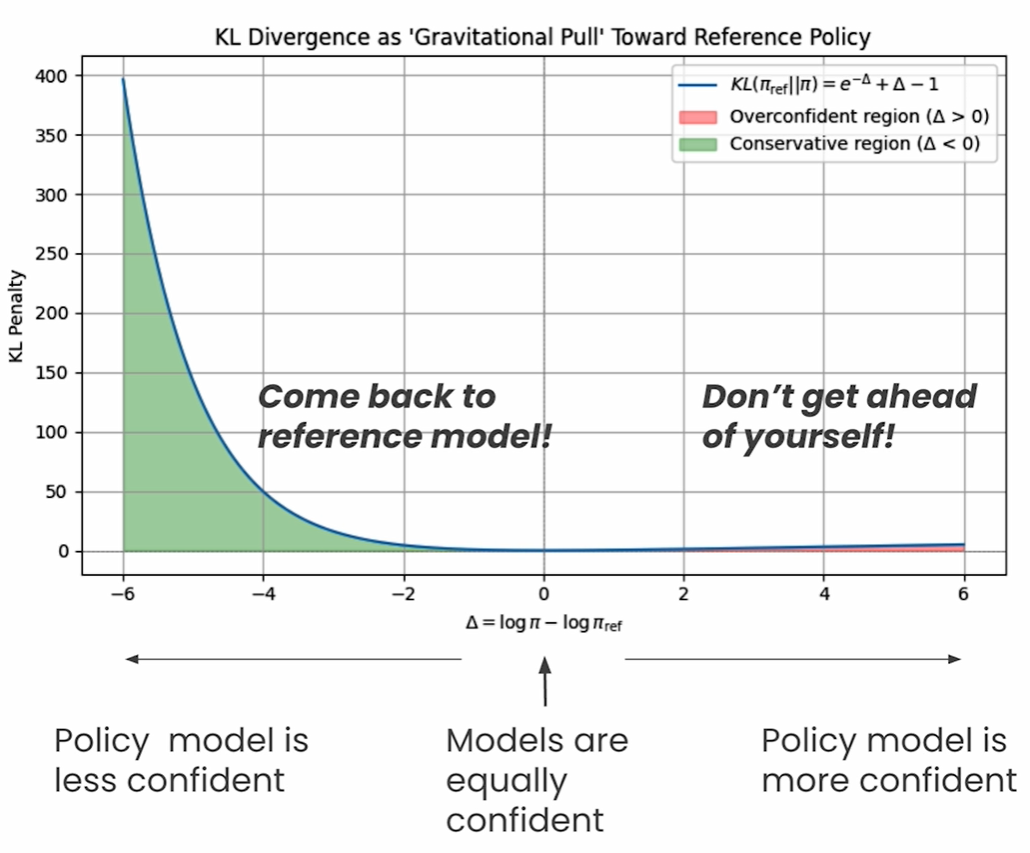

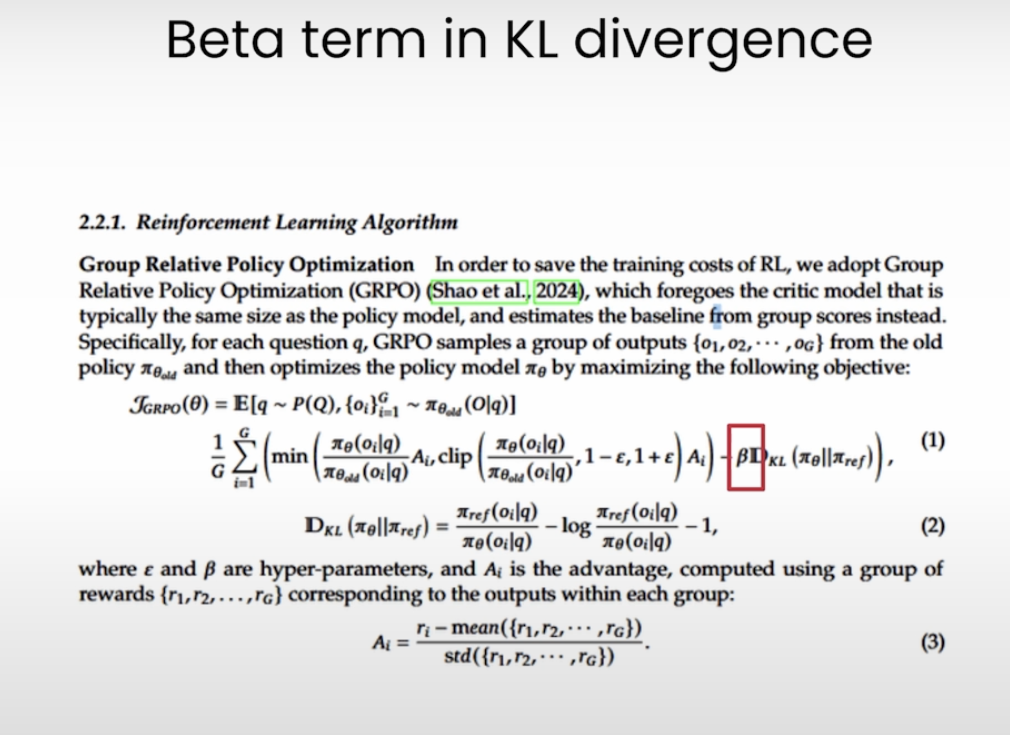

In [ ]:
for beta in [0, 0.1, 0.5]:
    loss = grpo_loss_with_kl(
        model,
        ref_model,
        prompt,
        "fence and",
        advantage=2.0,
        epsilon=0.2,
        beta=beta
    )
    print(f"beta={beta}")
    print(f"loss={loss.item():.3f}")
    print()